### Demo of NoGAN Library and comparison with GAN library (CTGAN)

##### Import packages `genai_evaluation` & `nogan_synthesizer`

In [1]:
!pip install -U genai_evaluation nogan_synthesizer

  Using cached genai_evaluation-0.1.5-py2.py3-none-any.whl (6.0 kB)
  Using cached nogan_synthesizer-0.1.5-py2.py3-none-any.whl (8.1 kB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from genai_evaluation import multivariate_ecdf, ks_statistic
from nogan_synthesizer import NoGANSynth
from nogan_synthesizer.preprocessing import wrap_category_columns, unwrap_category_columns
from ctgan import CTGAN
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### Set Seed

In [3]:
pd.core.common.random_state(None)
seed = 1047
ks_seed = 1000

In [4]:

# Default plot settings
plt.rcParams["figure.dpi"] = 300
sns.set()

##### Default Plot Settings

#### Read Data
##### Ref: 
https://archive-beta.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [5]:
#--- [1] read data, feature selection, remove missing values

url = "https://raw.githubusercontent.com/VincentGranville/Main/main/students.csv"
data = pd.read_csv(url)

data = data.drop(data[data["Curricular_units_2nd_sem_grade"] == 0].index)

features = [
  'Curricular_units_2nd_sem_approved',
  'Curricular_units_2nd_sem_grade',
  'Curricular_units_1st_sem_approved',
  'Curricular_units_1st_sem_grade',
  'Admission_grade',
  'Tuition_fees_up_to_date',
  'Curricular_units_2nd_sem_evaluations',
  'Age_at_enrollment',
  'Previous_qualification_grade',
  'Curricular_units_1st_sem_evaluations',
  'Course',
  'Father_occupation',
  'Mother_occupation',
  'Unemployment_rate',
  'GDP', 
  'Application_mode',
  'Father_qualification',
  'Curricular_units_2nd_sem_enrolled',
  'Mother_qualification',
  'Inflation_rate',
  'Target']

data = data[features]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3554 entries, 1 to 4423
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Curricular_units_2nd_sem_approved     3554 non-null   int64  
 1   Curricular_units_2nd_sem_grade        3554 non-null   float64
 2   Curricular_units_1st_sem_approved     3554 non-null   int64  
 3   Curricular_units_1st_sem_grade        3554 non-null   float64
 4   Admission_grade                       3554 non-null   float64
 5   Tuition_fees_up_to_date               3554 non-null   int64  
 6   Curricular_units_2nd_sem_evaluations  3554 non-null   int64  
 7   Age_at_enrollment                     3554 non-null   int64  
 8   Previous_qualification_grade          3554 non-null   float64
 9   Curricular_units_1st_sem_evaluations  3554 non-null   int64  
 10  Course                                3554 non-null   int64  
 11  Father_occupation     

In [7]:
cat_cols = ['Course', 'Father_occupation', 'Mother_occupation', 
            'Unemployment_rate', 'GDP', 'Inflation_rate',
            'Application_mode', 'Father_qualification',
            'Mother_qualification', 'Tuition_fees_up_to_date', 'Target'
            ]

num_cols = [f for f in features if f not in cat_cols]

##### Split Data into Training & Validation

In [8]:
training_data = data.sample(frac = 0.5)
validation_data = data.drop(training_data.index)

print(f"Data Shape: {data.shape}")
print(f"Training Shape: {training_data.shape}")
print(f"Validation Shape: {validation_data.shape}") 

Data Shape: (3554, 21)
Training Shape: (1777, 21)
Validation Shape: (1777, 21)


##### Preprocess Categorical Columns

In [9]:
wrapped_train_data, idx_to_key_train, key_to_idx_train = \
                    wrap_category_columns(training_data,cat_cols)
                    
wrapped_val_data, idx_to_key_val, key_to_idx_val = \
                    wrap_category_columns(validation_data,cat_cols)

In [10]:
print(f"Wrapped Training Data Shape: {wrapped_train_data.shape}")
print(f"Wrapped Validation Data Shape: {wrapped_val_data.shape}") 
print(wrapped_train_data.info())

Wrapped Training Data Shape: (1777, 11)
Wrapped Validation Data Shape: (1777, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 1777 entries, 2062 to 3279
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Curricular_units_2nd_sem_approved     1777 non-null   int64  
 1   Curricular_units_2nd_sem_grade        1777 non-null   float64
 2   Curricular_units_1st_sem_approved     1777 non-null   int64  
 3   Curricular_units_1st_sem_grade        1777 non-null   float64
 4   Admission_grade                       1777 non-null   float64
 5   Curricular_units_2nd_sem_evaluations  1777 non-null   int64  
 6   Age_at_enrollment                     1777 non-null   int64  
 7   Previous_qualification_grade          1777 non-null   float64
 8   Curricular_units_1st_sem_evaluations  1777 non-null   int64  
 9   Curricular_units_2nd_sem_enrolled     1777 non-null   int64  
 10  cat_

Function wrap_category_columns
* Returns wrapped data with encoded columns & idx_to_key dictionary
* idx_to_key_train has the encoded key and the column values

In [11]:
# idx_to_key_train contents
print({key: idx_to_key_train[key] for key in list(idx_to_key_train)[:10]})

{1: (9500, 9, 9, 12.7, -1.7, 3.7, 1, 1, 1, 1, 'Graduate'), 2: (9500, 10, 5, 13.9, 0.79, -0.3, 1, 3, 1, 1, 'Graduate'), 3: (9130, 5, 5, 11.1, 2.02, 0.6, 39, 1, 3, 1, 'Dropout'), 4: (9500, 5, 5, 13.9, 0.79, -0.3, 42, 1, 1, 1, 'Dropout'), 5: (9556, 7, 3, 13.9, 0.79, -0.3, 39, 37, 37, 1, 'Graduate'), 6: (9238, 7, 9, 12.4, 1.79, 0.5, 1, 38, 19, 1, 'Graduate'), 7: (9085, 2, 2, 13.9, 0.79, -0.3, 44, 3, 3, 1, 'Graduate'), 8: (9991, 9, 9, 7.6, 0.32, 2.6, 39, 37, 37, 1, 'Dropout'), 9: (9147, 6, 5, 9.4, -3.12, -0.8, 17, 38, 19, 1, 'Enrolled'), 10: (9254, 3, 9, 9.4, -3.12, -0.8, 43, 37, 38, 1, 'Graduate')}


##### Fit the model

In [12]:
# bin_values is a hyperparameter
bin_values = [100] * len(wrapped_train_data.columns)

# Instantiate model
nogan = NoGANSynth(wrapped_train_data,random_seed=seed)

# fit model
nogan.fit(bins = bin_values)

#### Generate Synthetic Data (Original NoGAN, Gaussian & Uniform)

In [13]:
stretch_type_gaussian  = (["Gaussian"] * (len(wrapped_train_data.columns)-1)) + ["Uniform"]
stretch_nogan_orig  = [-1] * len(wrapped_train_data.columns)

print("Synth. NoGAN Original:")
wrapped_nogan_orig_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True ,
                                                         stretch = stretch_nogan_orig
                                                         )
print("\nSynth. NoGAN Gaussian:")
wrapped_nogan_gauss_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True ,
                                                         stretch_type= stretch_type_gaussian
                                                         )
print("\nSynth. NoGAN Uniform:")
wrapped_nogan_uniform_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True ,
                                                         )
print()

Synth. NoGAN Original:
List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]

Synth. NoGAN Gaussian:
List `stretch_type`: ['Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Synth. NoGAN Uniform:
List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]



In [14]:
print(f"wrapped_nogan_orig_synth_data Shape: {wrapped_nogan_orig_synth_data.shape}")
print(f"wrapped_nogan_gauss_synth_data Shape: {wrapped_nogan_gauss_synth_data.shape}")
print(f"wrapped_nogan_uniform_synth_data Shape: {wrapped_nogan_uniform_synth_data.shape}")

wrapped_nogan_orig_synth_data Shape: (1777, 11)
wrapped_nogan_gauss_synth_data Shape: (1777, 11)
wrapped_nogan_uniform_synth_data Shape: (1777, 11)


##### Evaluate using ECDF & KS Stat

In [15]:
query_val_vs_synth, ecdf_val1, ecdf_nogan_orig_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_orig_synth_data, 
                              n_nodes = 1000, 
                              verbose = True,
                              random_seed=ks_seed)

_, ecdf_val2, ecdf_nogan_gauss_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_gauss_synth_data, 
                              n_nodes = 1000, 
                              verbose = True,
                              random_seed=ks_seed)            

_, ecdf_val3, ecdf_nogan_uniform_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_uniform_synth_data, 
                              n_nodes = 1000, 
                              verbose = True,
                              random_seed=ks_seed)
            
_, ecdf_val4, ecdf_train = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_train_data, 
                              n_nodes = 1000, 
                              verbose = True,
                              random_seed=ks_seed)            
print()            
ks_stat_nogan_orig = ks_statistic(ecdf_val1, ecdf_nogan_orig_synth)
ks_stat_nogan_gauss = ks_statistic(ecdf_val2, ecdf_nogan_gauss_synth)
ks_stat_nogan_uniform = ks_statistic(ecdf_val3, ecdf_nogan_uniform_synth)
ks_stat_train = ks_statistic(ecdf_val4, ecdf_train)

print(f"KS Stat NoGAN Original(Synth vs Validation): {ks_stat_nogan_orig:.5f}")
print(f"KS Stat NoGAN Gauss (Synth vs Validation): {ks_stat_nogan_gauss:.5f}")
print(f"KS Stat NoGAN Uniform (Synth vs Validation): {ks_stat_nogan_uniform:.5f}")
print(f"Base KS Stat (Synth vs Train): {ks_stat_train:.5f}")

Sampling ecdf, location = 0


Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, l

##### Sample Queries Generated by multivariate ECDF function

In [16]:
for query in query_val_vs_synth[:3]:
    print()
    print(query)


Curricular_units_2nd_sem_approved <= 5.0000000001 and Curricular_units_2nd_sem_grade <= 15.5000000001 and Curricular_units_1st_sem_approved <= 7.0000000001 and Curricular_units_1st_sem_grade <= 16.1666666701 and Admission_grade <= 140.28041722570174 and Curricular_units_2nd_sem_evaluations <= 12.0000000001 and Age_at_enrollment <= 52.37636850463373 and Previous_qualification_grade <= 140.57860006111918 and Curricular_units_1st_sem_evaluations <= 9.0000000001 and Curricular_units_2nd_sem_enrolled <= 11.0000000001 and cat_label <= 1615.8370858235774

Curricular_units_2nd_sem_approved <= 8.0000000001 and Curricular_units_2nd_sem_grade <= 14.6666666701 and Curricular_units_1st_sem_approved <= 5.0000000001 and Curricular_units_1st_sem_grade <= 13.8333333301 and Admission_grade <= 138.21769944984115 and Curricular_units_2nd_sem_evaluations <= 19.0000000001 and Age_at_enrollment <= 27.100432726343296 and Previous_qualification_grade <= 145.6769190989075 and Curricular_units_1st_sem_evaluatio

##### Expand Categorical Columns in Synth Data

In [17]:
nogan_orig_synth_data = unwrap_category_columns(data=wrapped_nogan_orig_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)
nogan_orig_synth_data = nogan_orig_synth_data[features]

nogan_gauss_synth_data = unwrap_category_columns(data=wrapped_nogan_gauss_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)
nogan_gauss_synth_data = nogan_gauss_synth_data[features]

nogan_uniform_synth_data = unwrap_category_columns(data=wrapped_nogan_uniform_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)
nogan_uniform_synth_data = nogan_uniform_synth_data[features]

In [18]:
%matplotlib inline

##### Evaluate Scatterplots (NoGAN)

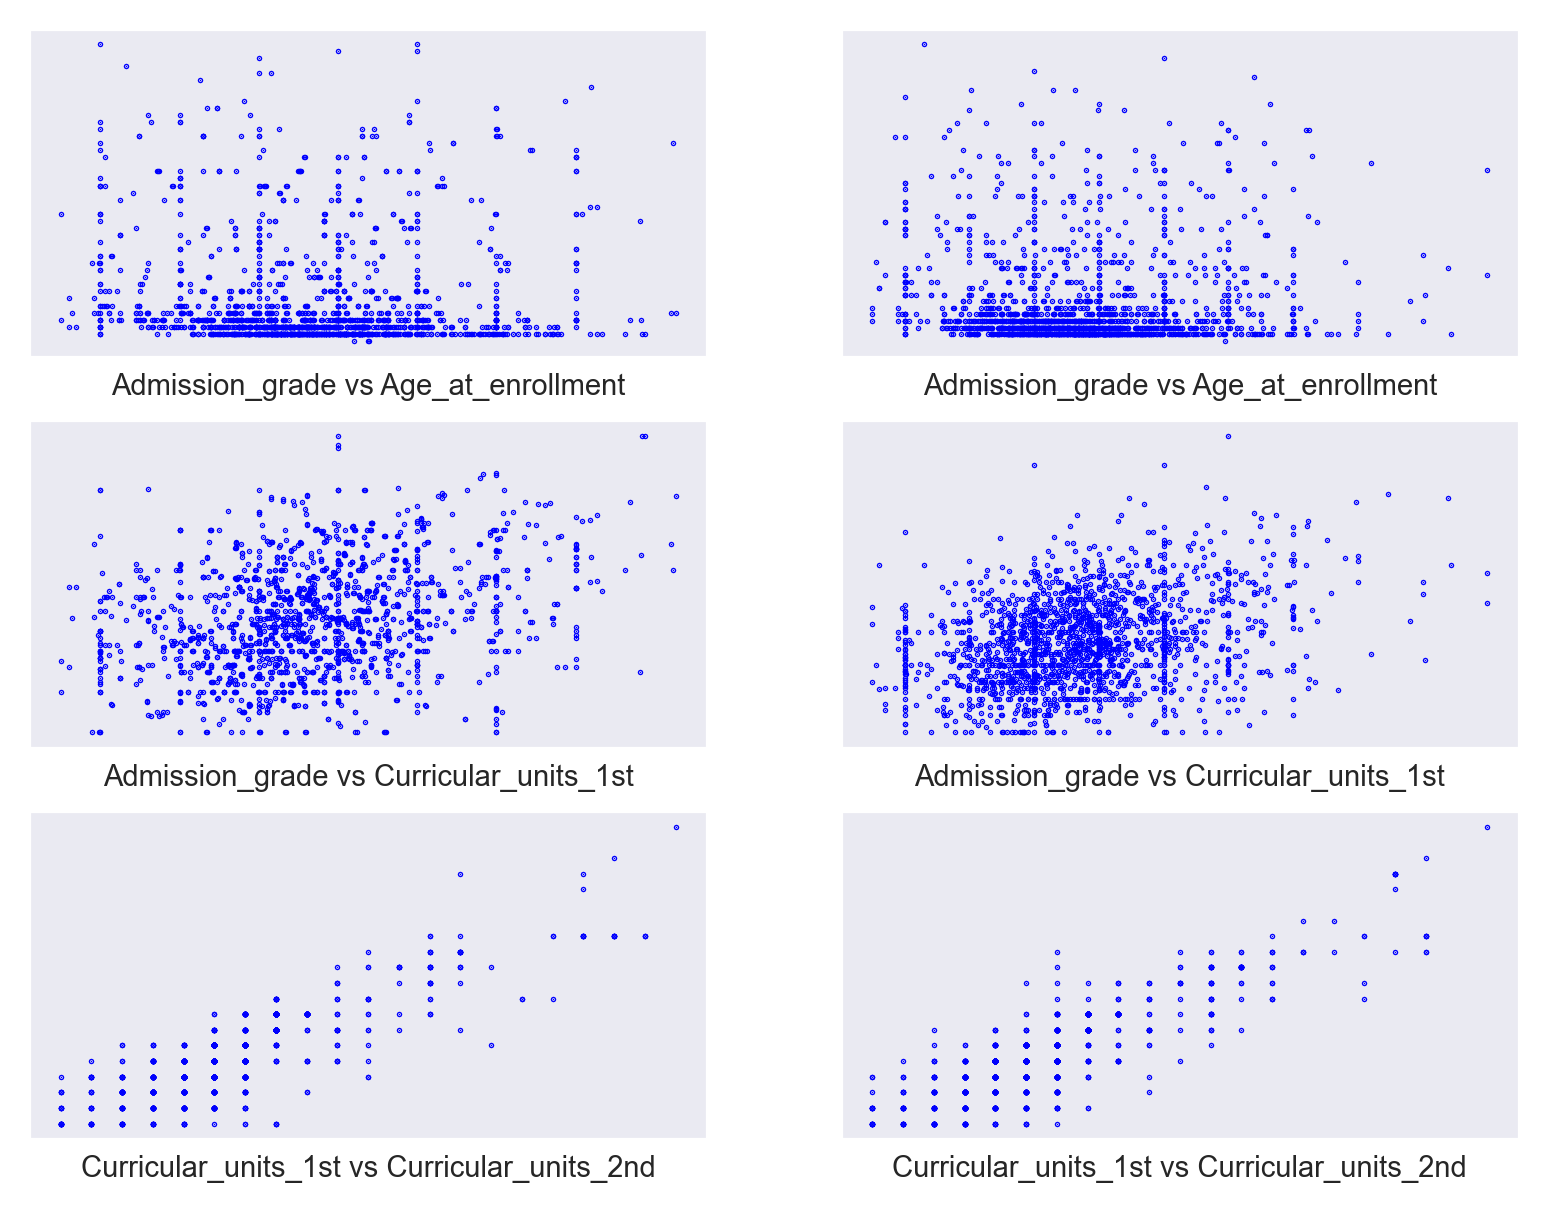

In [26]:
dfs_orig = nogan_orig_synth_data
dfs_gauss = nogan_gauss_synth_data
dfs_uniform = nogan_uniform_synth_data
dfv = validation_data

def vg_scatter(df, feature1, feature2, counter, xlim, ylim):

    # customized plots, subplot position based on counter

    label = feature1[0:20] + " vs " + feature2[0:20]    
    df = df[(df[feature1] >= xlim[0]) & 
            (df[feature1] <= xlim[1]) &
            (df[feature2] >= ylim[0]) &
            (df[feature2] <= ylim[1])
           ]
    x = df[feature1].to_numpy()
    y = df[feature2].to_numpy()
    plt.subplot(3, 2, counter)
    plt.scatter(x, y, s = 0.1, c ="blue")
    plt.xlabel(label, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    return()

plt.rcParams['axes.linewidth'] = 0.3

[col1, col2] = [features[4], features[7]]
xlim = [min(dfv[col1]), max(dfv[col1])]
ylim = [min(dfv[col2]), max(dfv[col2])]
vg_scatter(dfs_uniform, col1, col2, 1, xlim, ylim)
vg_scatter(dfv, col1, col2, 2, xlim, ylim)

[col1, col2] = [features[4], features[3]]
xlim = [min(dfv[col1]), max(dfv[col1])]
ylim = [10, max(dfv[features[3]])]
vg_scatter(dfs_uniform, features[4], features[3], 3, xlim, ylim)
vg_scatter(dfv, features[4], features[3], 4, xlim, ylim)

[col1, col2] = [features[2], features[0]]
xlim = [min(dfv[features[2]]), max(dfv[features[0]])]
ylim = [min(dfv[features[2]]), max(dfv[features[0]])]
vg_scatter(dfs_uniform, features[2], features[0], 5, xlim, ylim)
vg_scatter(dfv, features[2], features[0], 6, xlim, ylim)

plt.show()

##### Evaluate Target Categorical Column (NoGAN)

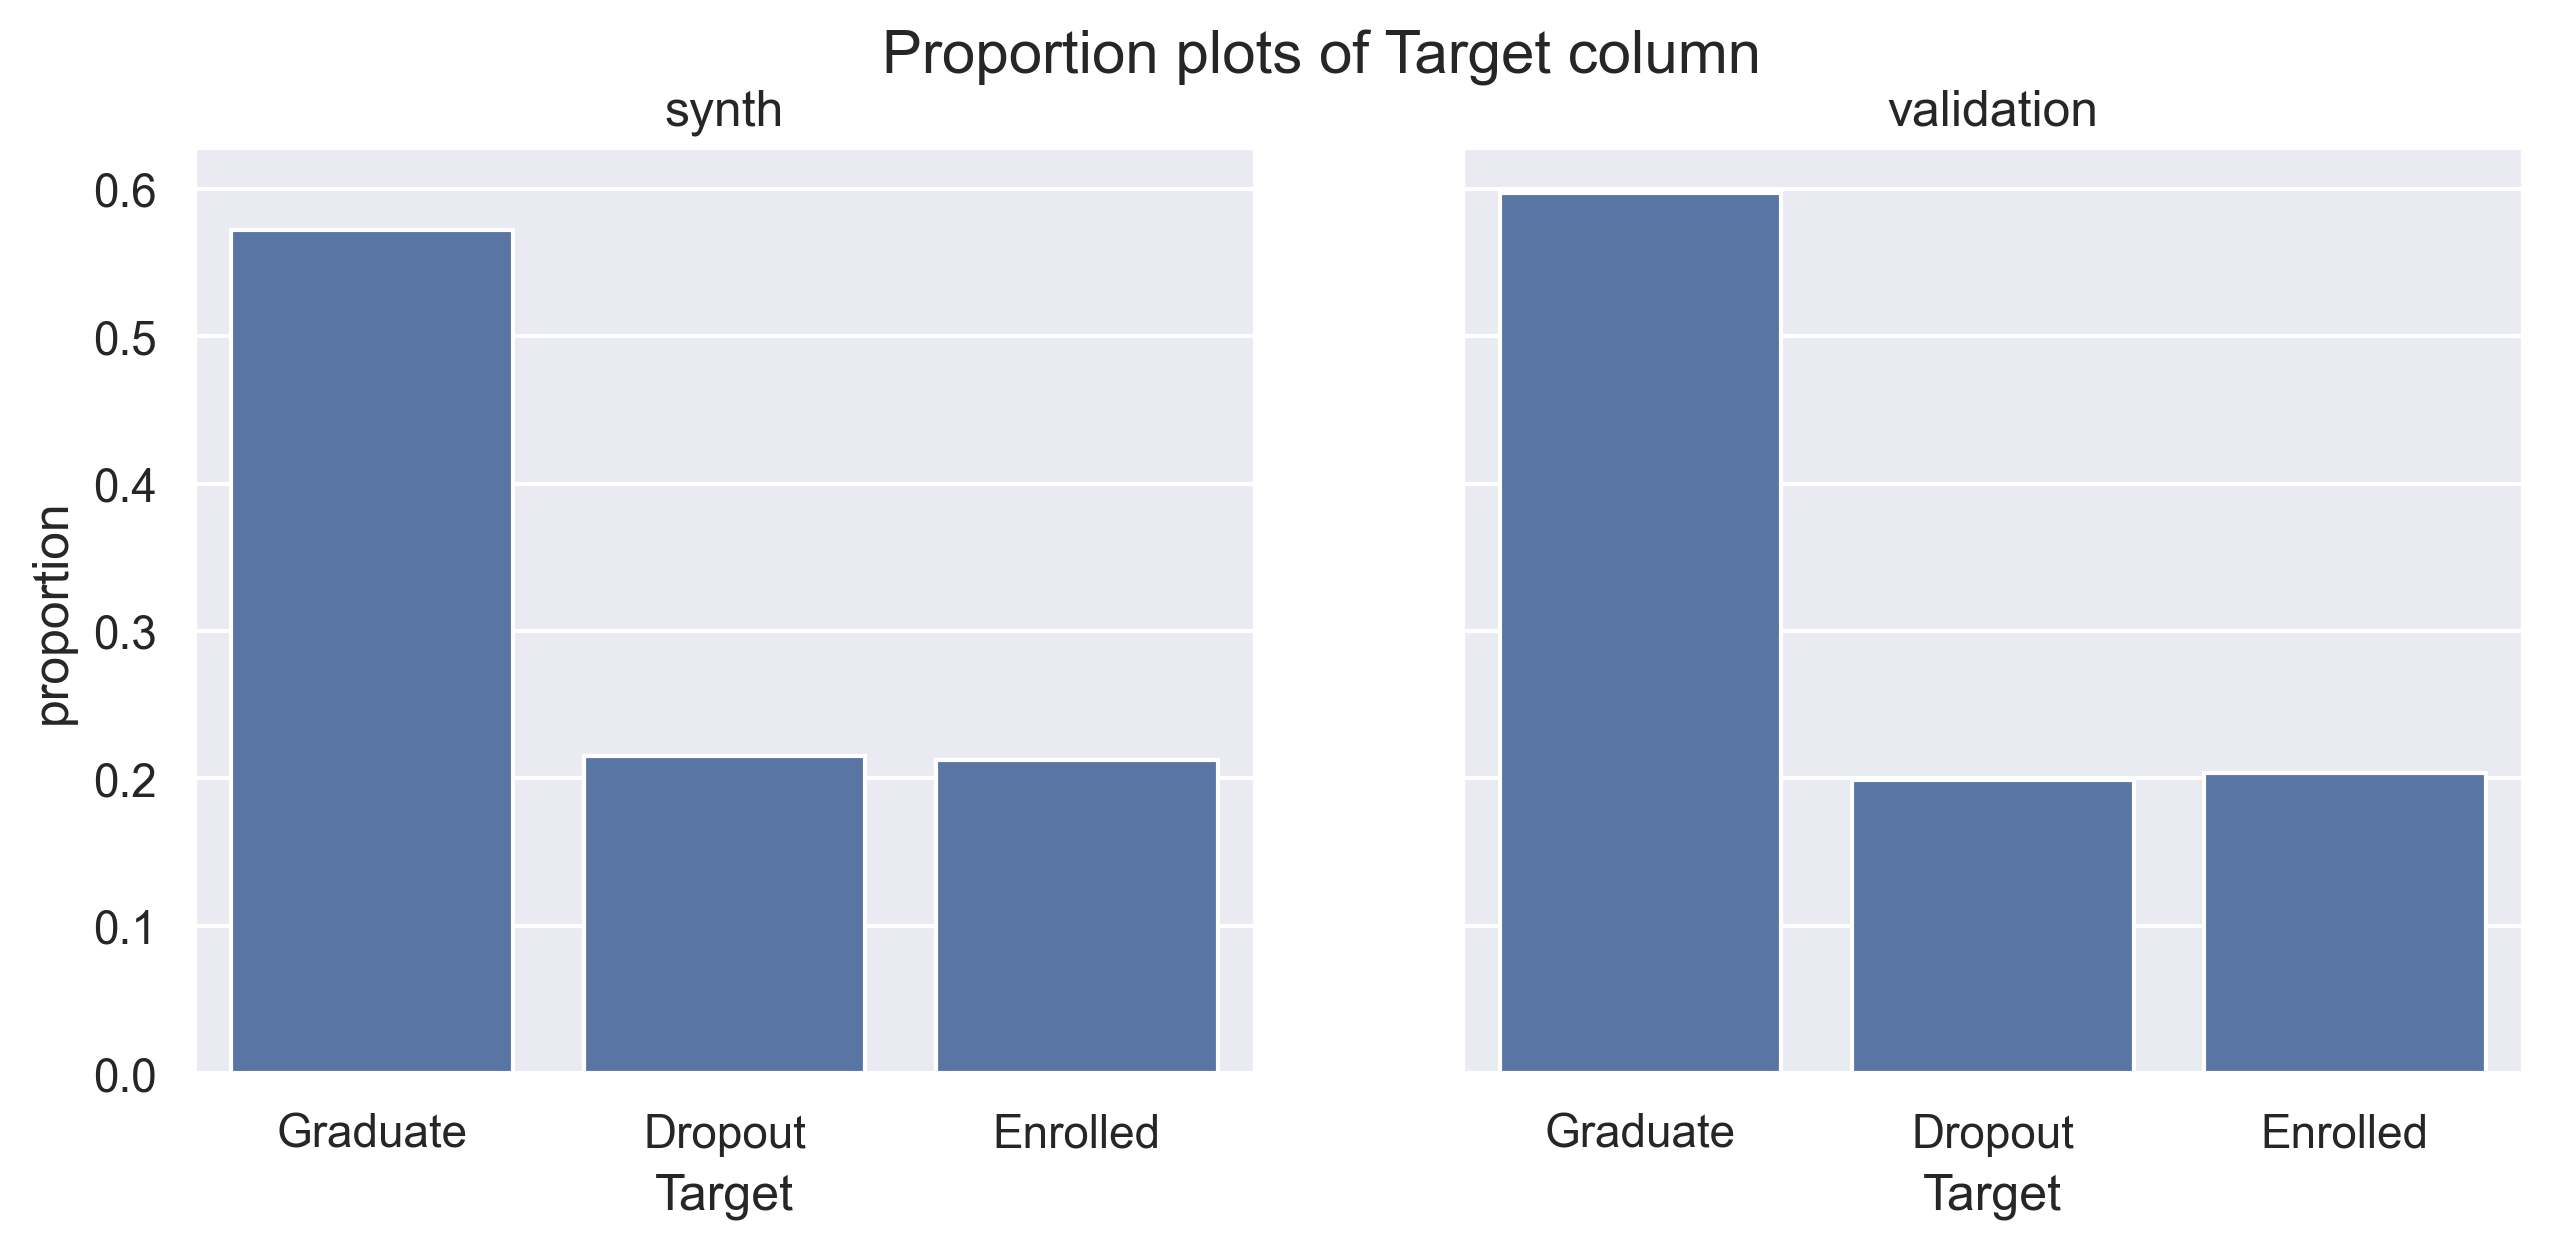

In [20]:
target_column = 'Target'
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

synth_label = dfs_uniform[target_column].value_counts(normalize = True).reset_index()
val_label = dfv[target_column].value_counts(normalize = True).reset_index()

sns.barplot(data = synth_label, x = target_column, y = "proportion", ax = ax[0])
ax[0].set_title("synth")

sns.barplot(data = val_label, x = target_column, y = "proportion",  ax = ax[1])
ax[1].set_title("validation")

plt.suptitle("Proportion plots of Target column")
plt.show()

##### Fit CTGAN

In [21]:
# Instantiate CTGAN
ctgan = CTGAN(verbose=False)

# Fit Training Data
ctgan.fit(training_data, discrete_columns = cat_cols, epochs = 200 )

# Sample Data
ctgan_synth_data = ctgan.sample(len(training_data))



In [22]:
ctgan_synth_data = ctgan_synth_data[features]
print(ctgan_synth_data.shape)

(1777, 21)


##### Evaluate Scatterplot (CTGAN)

()

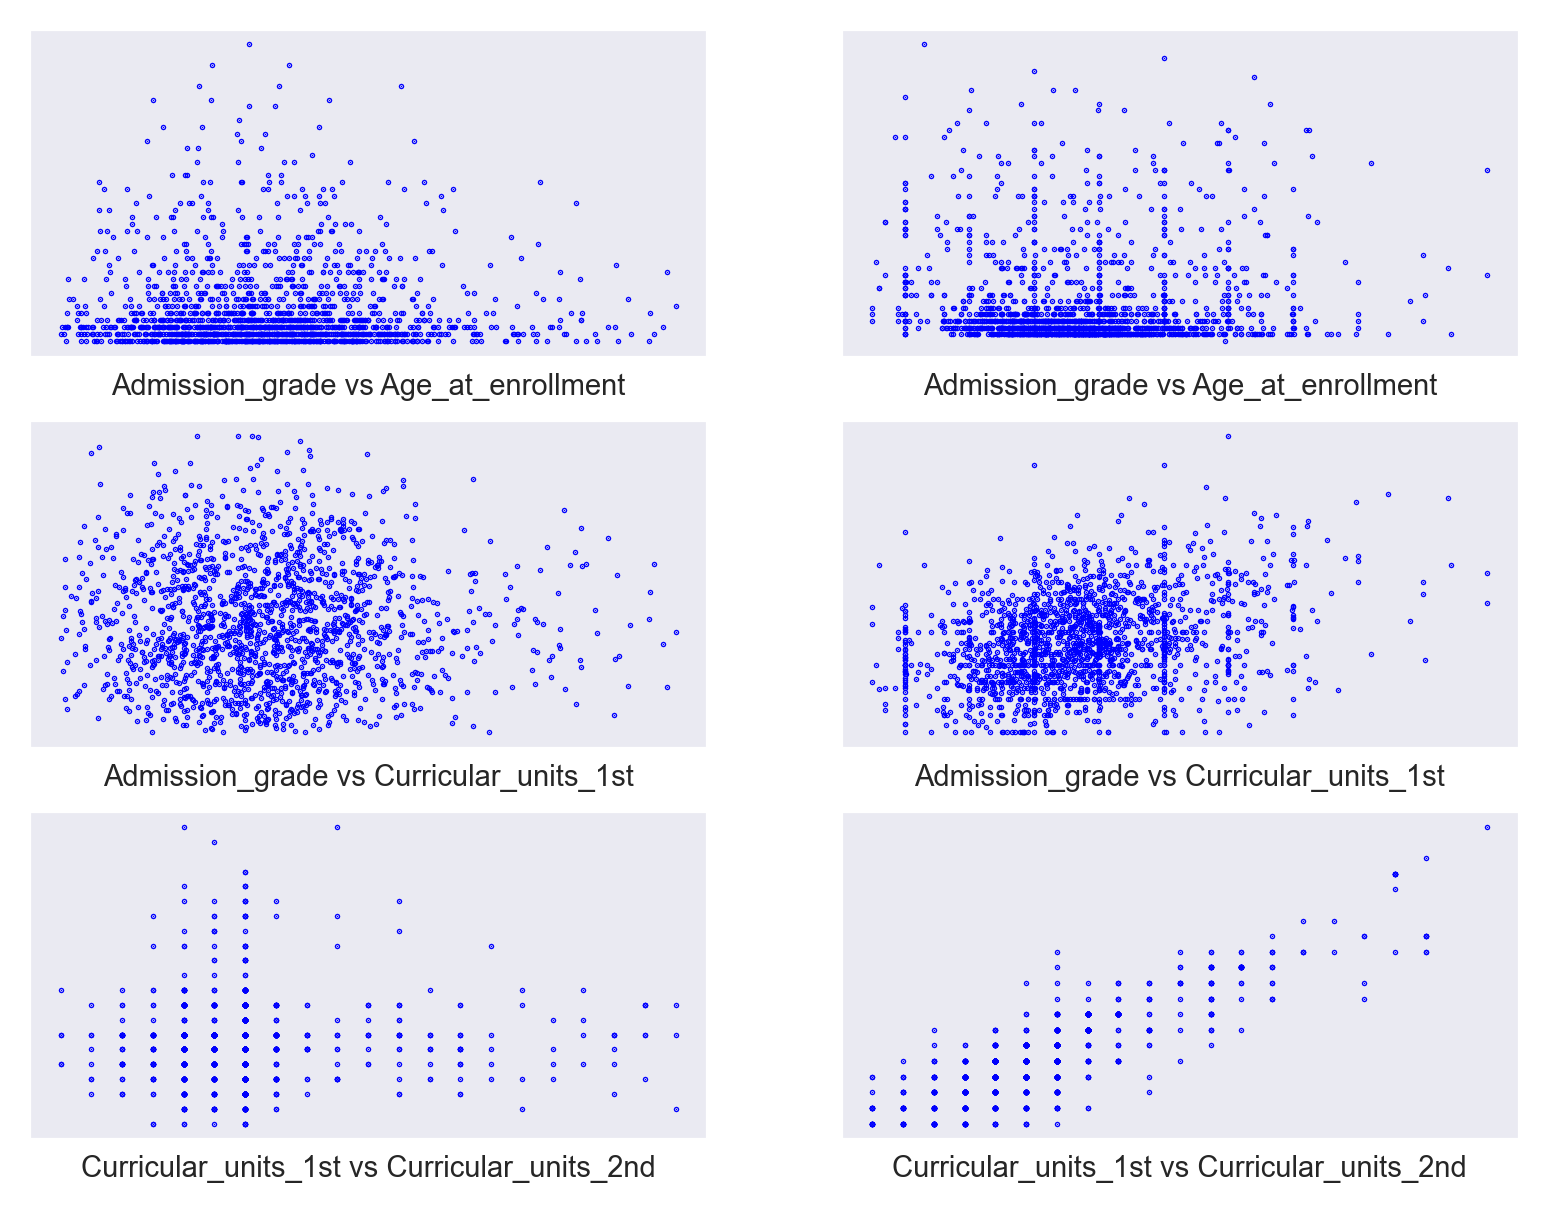

In [23]:
dfs_gan = ctgan_synth_data.copy()
[col1, col2] = [features[4], features[7]]
xlim = [min(dfv[col1]), max(dfv[col1])]
ylim = [min(dfv[col2]), max(dfv[col2])]
vg_scatter(dfs_gan, col1, col2, 1, xlim, ylim)
vg_scatter(dfv, col1, col2, 2, xlim, ylim)

[col1, col2] = [features[4], features[3]]
xlim = [min(dfv[col1]), max(dfv[col1])]
ylim = [10, max(dfv[features[3]])]
vg_scatter(dfs_gan, features[4], features[3], 3, xlim, ylim)
vg_scatter(dfv, features[4], features[3], 4, xlim, ylim)

[col1, col2] = [features[2], features[0]]
xlim = [min(dfv[features[2]]), max(dfv[features[0]])]
ylim = [min(dfv[features[2]]), max(dfv[features[0]])]
vg_scatter(dfs_gan, features[2], features[0], 5, xlim, ylim)
vg_scatter(dfv, features[2], features[0], 6, xlim, ylim)

##### Evaluate Target Categorical Column (CTGAN)

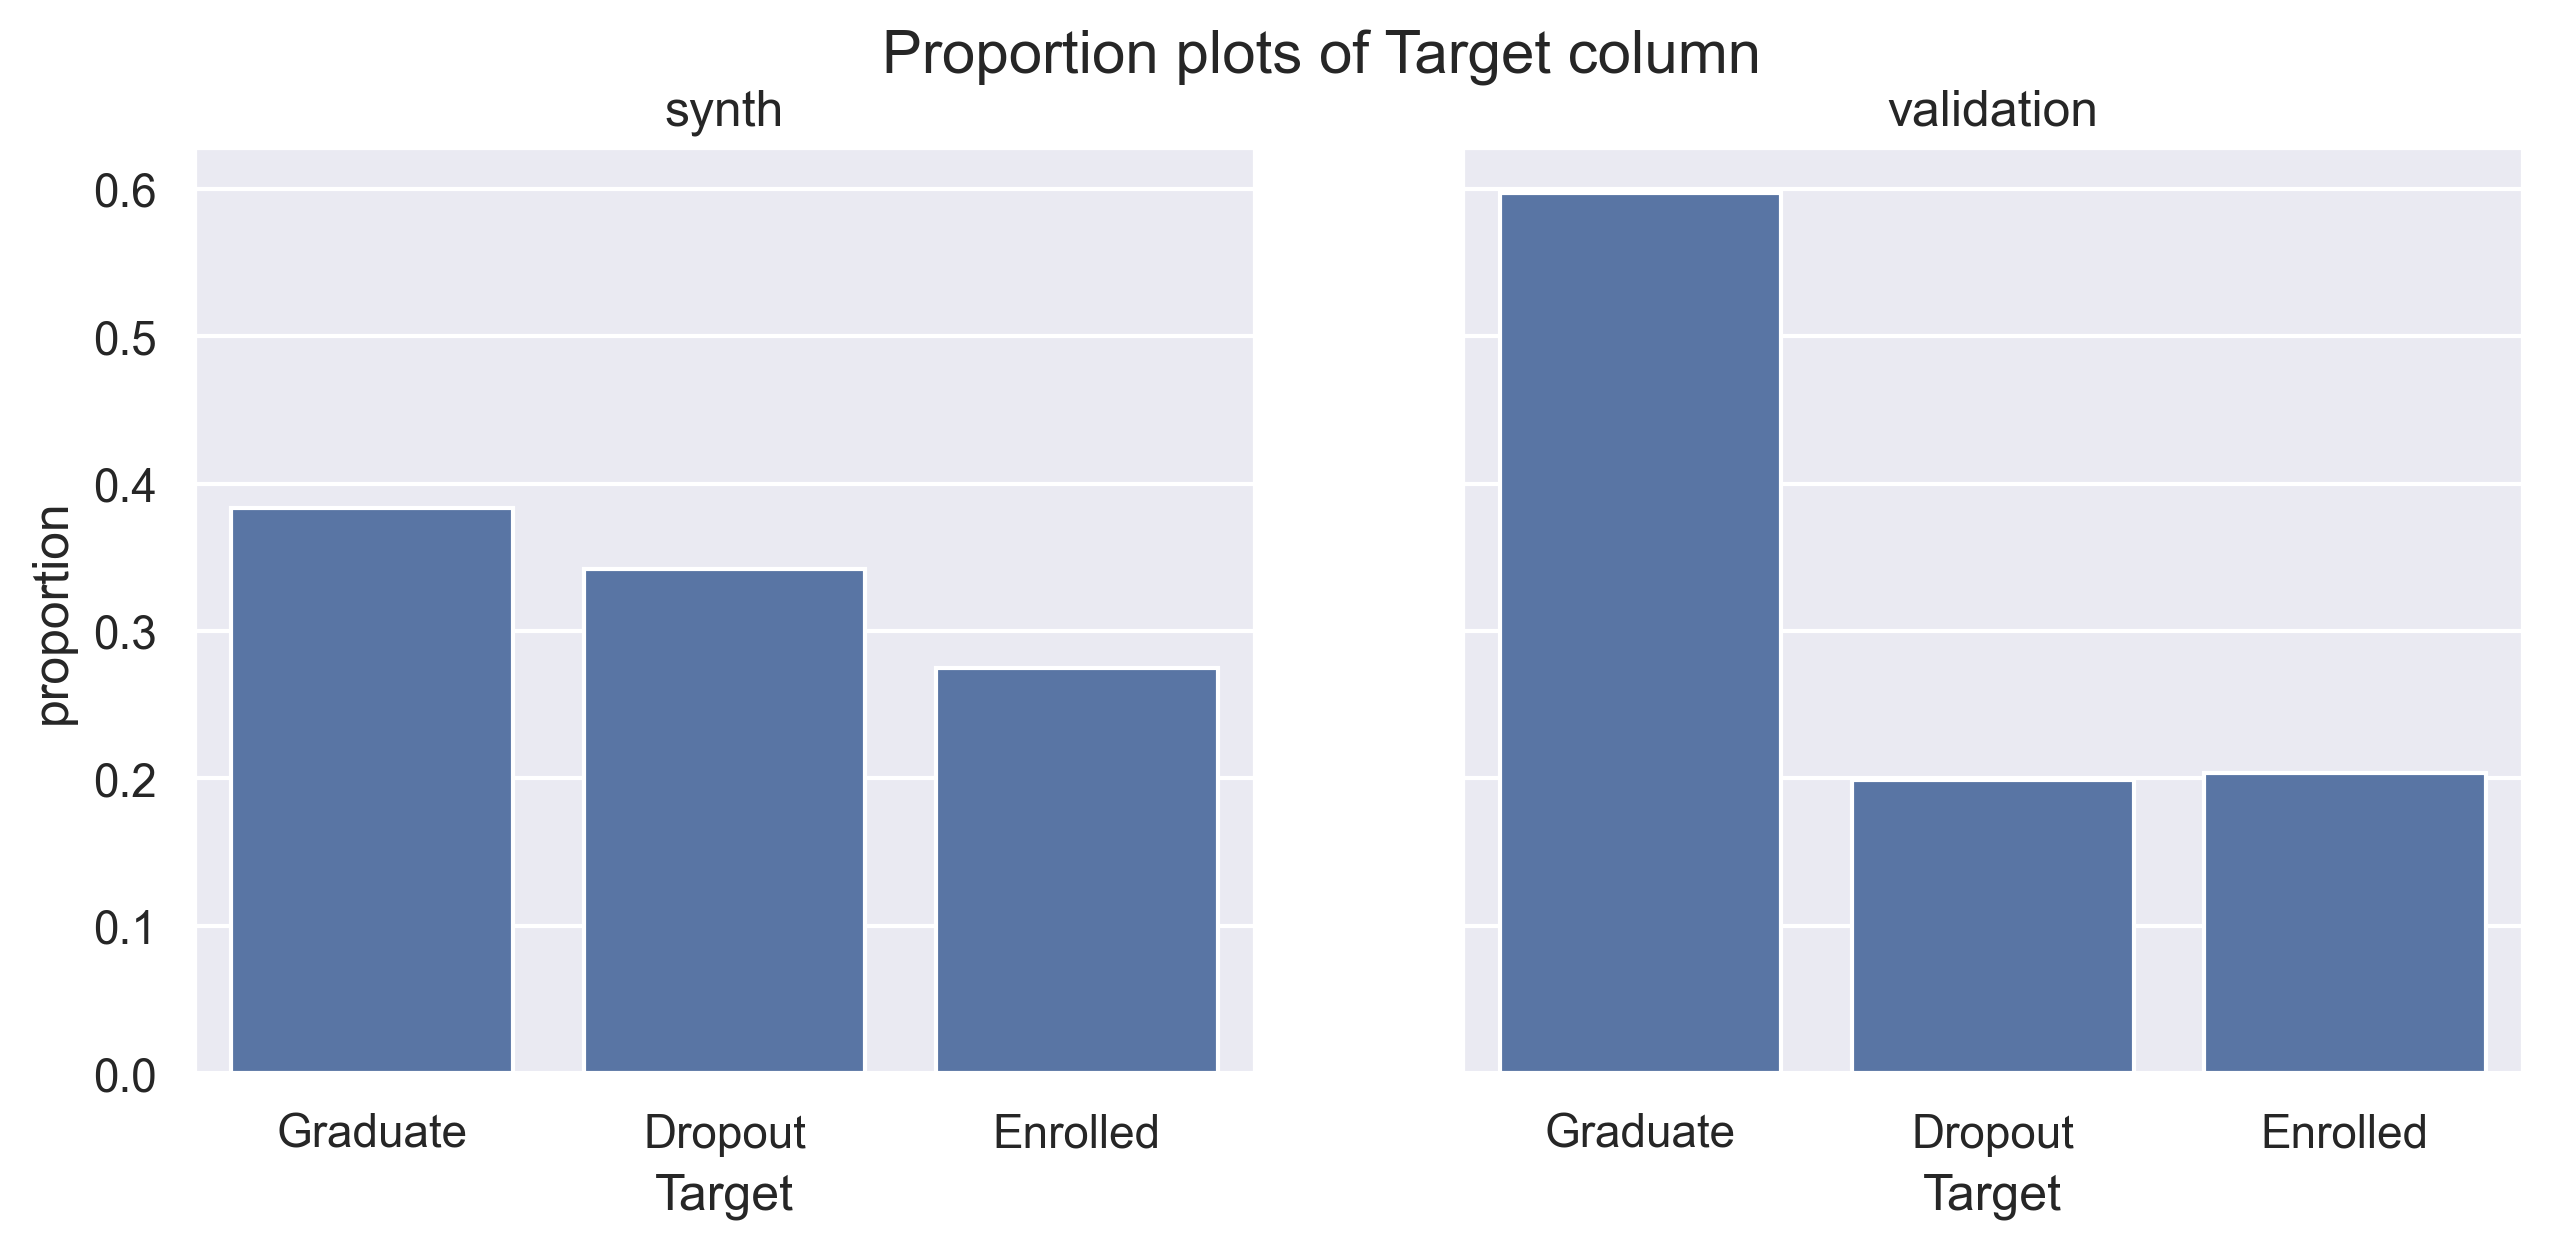

In [24]:
target_column = 'Target'
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

synth_label = dfs_gan[target_column].value_counts(normalize = True).reset_index()
val_label = dfv[target_column].value_counts(normalize = True).reset_index()

sns.barplot(data = synth_label, x = target_column, y = "proportion", ax = ax[0])
ax[0].set_title("synth")

sns.barplot(data = val_label, x = target_column, y = "proportion",  ax = ax[1])
ax[1].set_title("validation")

plt.suptitle("Proportion plots of Target column")
plt.show()